In [21]:
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import datetime


In [22]:
start_date = datetime.datetime(1960, 1, 1)
end_date = datetime.datetime.now()
fred_series_id = 'CPIAUCSL'
raw_cpi_data = web.DataReader(fred_series_id, 'fred', start_date, end_date)

# Display head and tail to verify
print("--- Raw CPI Data Head (from 1960) ---")
print(raw_cpi_data.head())
print("\n--- Raw CPI Data Tail ---")
print(raw_cpi_data.tail())

--- Raw CPI Data Head (from 1960) ---
            CPIAUCSL
DATE                
1960-01-01     29.37
1960-02-01     29.41
1960-03-01     29.41
1960-04-01     29.54
1960-05-01     29.57

--- Raw CPI Data Tail ---
            CPIAUCSL
DATE                
2025-04-01   320.321
2025-05-01   320.580
2025-06-01   321.500
2025-07-01   322.132
2025-08-01   323.364


In [23]:
# Calculate YoY percentage change (comparing current month to 12 months ago)
inflation_rate_yoy = raw_cpi_data[fred_series_id].pct_change(periods=12) * 100

# Remove initial NaN values generated by pct_change
inflation_rate_yoy = inflation_rate_yoy.dropna()

# Store in a DataFrame with a clear column name
inflation_df = inflation_rate_yoy.to_frame(name='YoY_Inflation')

# Display head and tail to verify the calculation
print("--- Calculated YoY Inflation Head ---")
print(inflation_df.head())
print("\n--- Calculated YoY Inflation Tail ---")
print(inflation_df.tail())

--- Calculated YoY Inflation Head ---
            YoY_Inflation
DATE                     
1961-01-01       1.600272
1961-02-01       1.462088
1961-03-01       1.462088
1961-04-01       0.914015
1961-05-01       0.913088

--- Calculated YoY Inflation Tail ---
            YoY_Inflation
DATE                     
2025-04-01       2.333747
2025-05-01       2.375934
2025-06-01       2.672683
2025-07-01       2.731801
2025-08-01       2.939220


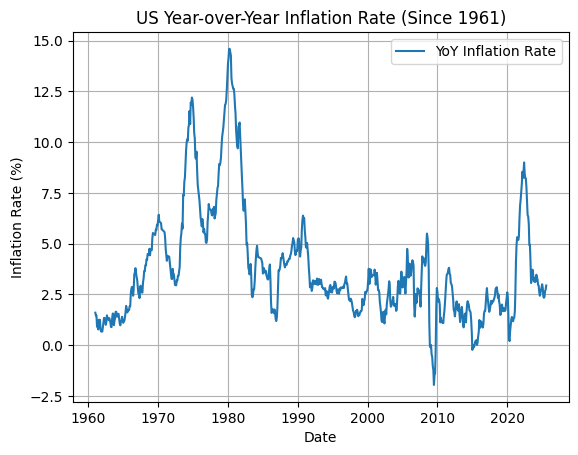

In [24]:
# Create the plot using the inflation_df DataFrame
plt.plot(inflation_df['YoY_Inflation'], label='YoY Inflation Rate')

# Add plot title and axis labels
plt.title('US Year-over-Year Inflation Rate (Since 1961)')
plt.xlabel('Date')
plt.ylabel('Inflation Rate (%)')

# Add a legend and grid for better readability
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

Training set size: 620 observations
Testing set size:  156 observations


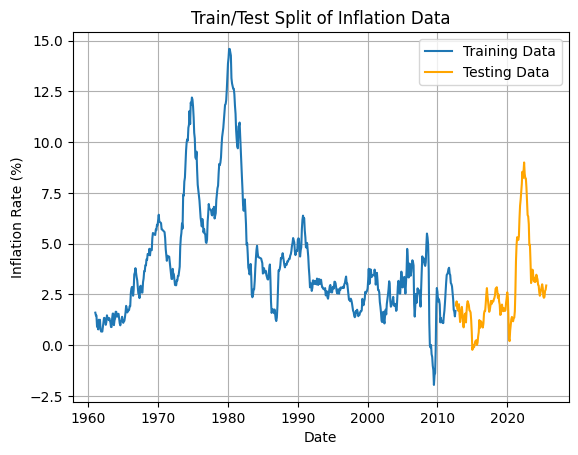

In [25]:
# Define the proportion of data to reserve for testing (e.g., 20%)
test_size_ratio = 0.2

# Split the data chronologically using pmdarima's helper function
train_set, test_set = train_test_split(inflation_df, test_size=test_size_ratio) # Removed shuffle=False

# Print the number of observations in each set
print(f"Training set size: {len(train_set)} observations")
print(f"Testing set size:  {len(test_set)} observations")

# Optional: Visualize the split
plt.plot(train_set['YoY_Inflation'], label='Training Data')
plt.plot(test_set['YoY_Inflation'], label='Testing Data', color='orange')
plt.title('Train/Test Split of Inflation Data')
plt.xlabel('Date')
plt.ylabel('Inflation Rate (%)')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
# Use auto_arima on the training data to find the best SARIMA parameters
auto_model_sarima = pm.auto_arima(
    train_set['YoY_Inflation'],
    seasonal=True,       # Enable searching for seasonal components
    m=12,                # Set seasonality period to 12 months (yearly)
    stepwise=True,       # Use efficient stepwise search algorithm
    suppress_warnings=True,# Hide convergence warnings during search
    error_action='ignore', # Skip models that fail to fit
    trace=True,          # Show the models being tested (helpful for learning)
    # Define search boundaries (optional but good practice)
    max_order=None,      # Allow high combined order if needed
    max_p=5, max_q=5,    # Max non-seasonal AR and MA orders
    max_P=2, max_Q=2,    # Max seasonal AR and MA orders
    max_d=2, max_D=1,    # Max differencing orders
    start_p=1, start_q=1,# Start search from simple models
    start_P=1, start_Q=1
)

# Print the summary of the best model found
print(auto_model_sarima.summary())

c:\Users\vandan_tank\Documents\inflation-forecasting\venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\vandan_tank\Documents\inflation-forecasting\venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\vandan_tank\Documents\inflation-forecasting\venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\vandan_tank\Documents\inflation-forecasting\venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\vandan_tank\Documents\inflation-forecasting\venv\lib\site-packages\

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=2.94 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=585.356, Time=0.11 sec


c:\Users\vandan_tank\Documents\inflation-forecasting\venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\vandan_tank\Documents\inflation-forecasting\venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=336.686, Time=0.53 sec


c:\Users\vandan_tank\Documents\inflation-forecasting\venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=213.744, Time=0.78 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=583.356, Time=0.09 sec


c:\Users\vandan_tank\Documents\inflation-forecasting\venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\vandan_tank\Documents\inflation-forecasting\venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=506.851, Time=0.15 sec


c:\Users\vandan_tank\Documents\inflation-forecasting\venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=215.741, Time=1.05 sec


c:\Users\vandan_tank\Documents\inflation-forecasting\venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=215.740, Time=3.05 sec


c:\Users\vandan_tank\Documents\inflation-forecasting\venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=366.462, Time=0.39 sec


c:\Users\vandan_tank\Documents\inflation-forecasting\venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=215.639, Time=4.47 sec


c:\Users\vandan_tank\Documents\inflation-forecasting\venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=354.927, Time=0.54 sec


c:\Users\vandan_tank\Documents\inflation-forecasting\venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=1.69 sec


c:\Users\vandan_tank\Documents\inflation-forecasting\venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,1)[12] intercept   : AIC=168.540, Time=1.05 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=489.915, Time=0.19 sec


c:\Users\vandan_tank\Documents\inflation-forecasting\venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\vandan_tank\Documents\inflation-forecasting\venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(1,0,1)[12] intercept   : AIC=170.528, Time=1.42 sec


c:\Users\vandan_tank\Documents\inflation-forecasting\venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,2)[12] intercept   : AIC=170.526, Time=4.48 sec


c:\Users\vandan_tank\Documents\inflation-forecasting\venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(1,0,0)[12] intercept   : AIC=343.828, Time=0.52 sec


c:\Users\vandan_tank\Documents\inflation-forecasting\venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(1,0,2)[12] intercept   : AIC=170.190, Time=5.75 sec


c:\Users\vandan_tank\Documents\inflation-forecasting\venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=inf, Time=3.69 sec


c:\Users\vandan_tank\Documents\inflation-forecasting\venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,3)(0,0,1)[12] intercept   : AIC=inf, Time=1.53 sec


c:\Users\vandan_tank\Documents\inflation-forecasting\venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,1)[12] intercept   : AIC=inf, Time=3.54 sec


c:\Users\vandan_tank\Documents\inflation-forecasting\venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,1)[12]             : AIC=166.648, Time=0.67 sec
 ARIMA(0,1,2)(0,0,0)[12]             : AIC=487.916, Time=0.12 sec


c:\Users\vandan_tank\Documents\inflation-forecasting\venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\vandan_tank\Documents\inflation-forecasting\venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(1,0,1)[12]             : AIC=168.623, Time=1.04 sec


c:\Users\vandan_tank\Documents\inflation-forecasting\venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,2)[12]             : AIC=168.618, Time=2.18 sec


c:\Users\vandan_tank\Documents\inflation-forecasting\venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(1,0,0)[12]             : AIC=341.847, Time=0.38 sec


c:\Users\vandan_tank\Documents\inflation-forecasting\venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(1,0,2)[12]             : AIC=168.343, Time=5.37 sec


c:\Users\vandan_tank\Documents\inflation-forecasting\venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[12]             : AIC=211.747, Time=0.68 sec


c:\Users\vandan_tank\Documents\inflation-forecasting\venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,1)[12]             : AIC=inf, Time=1.78 sec


c:\Users\vandan_tank\Documents\inflation-forecasting\venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,3)(0,0,1)[12]             : AIC=158.345, Time=1.11 sec
 ARIMA(0,1,3)(0,0,0)[12]             : AIC=488.672, Time=0.22 sec


c:\Users\vandan_tank\Documents\inflation-forecasting\venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\vandan_tank\Documents\inflation-forecasting\venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,3)(1,0,1)[12]             : AIC=159.634, Time=1.23 sec


c:\Users\vandan_tank\Documents\inflation-forecasting\venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,3)(0,0,2)[12]             : AIC=159.466, Time=3.66 sec


c:\Users\vandan_tank\Documents\inflation-forecasting\venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,3)(1,0,0)[12]             : AIC=342.380, Time=0.43 sec


c:\Users\vandan_tank\Documents\inflation-forecasting\venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,3)(1,0,2)[12]             : AIC=inf, Time=7.06 sec


c:\Users\vandan_tank\Documents\inflation-forecasting\venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,1)[12]             : AIC=inf, Time=1.88 sec


c:\Users\vandan_tank\Documents\inflation-forecasting\venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,4)(0,0,1)[12]             : AIC=inf, Time=0.95 sec


c:\Users\vandan_tank\Documents\inflation-forecasting\venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,4)(0,0,1)[12]             : AIC=inf, Time=2.58 sec

Best model:  ARIMA(0,1,3)(0,0,1)[12]          
Total fit time: 69.406 seconds
                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  620
Model:             SARIMAX(0, 1, 3)x(0, 0, [1], 12)   Log Likelihood                 -74.173
Date:                              Fri, 24 Oct 2025   AIC                            158.345
Time:                                      13:07:00   BIC                            180.486
Sample:                                  01-01-1961   HQIC                           166.952
                                       - 08-01-2012                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------

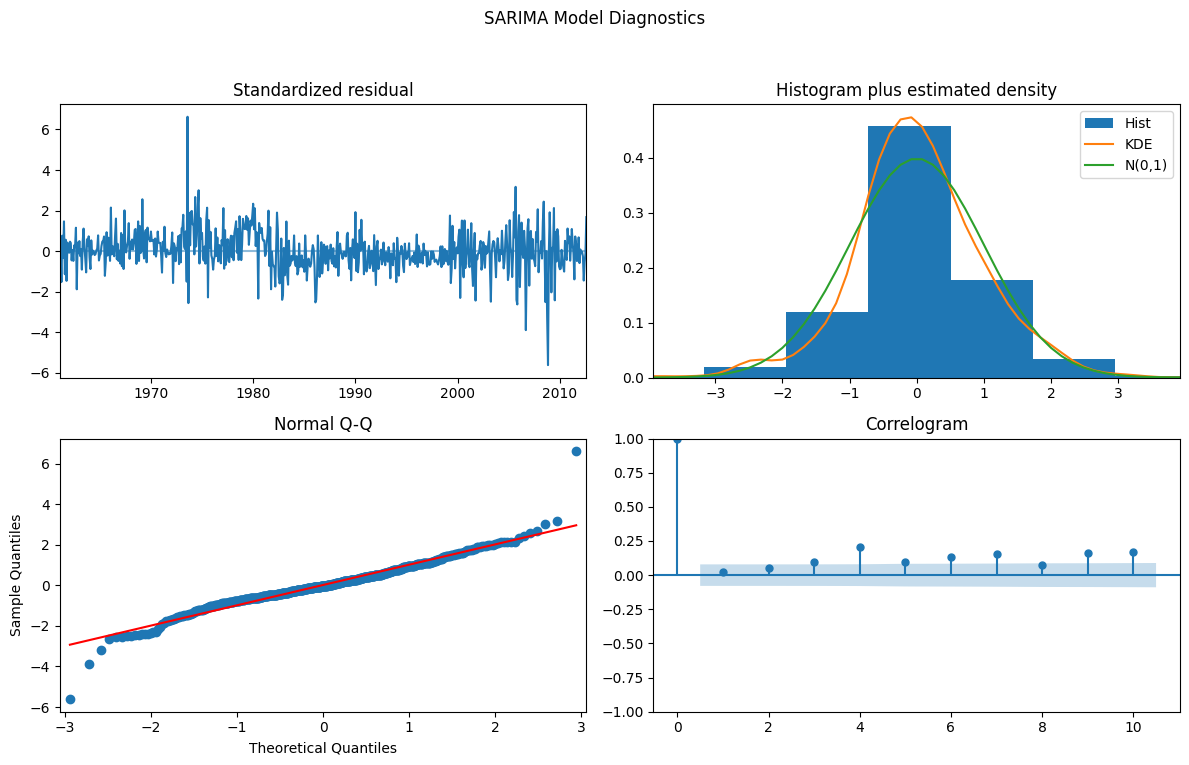

In [27]:
# Plot standard diagnostics for the fitted SARIMA model
auto_model_sarima.plot_diagnostics(figsize=(12, 8))
plt.suptitle("SARIMA Model Diagnostics") # Add an overall title
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()

In [28]:
# Determine the number of steps to forecast (length of the test set)
n_forecast_periods = len(test_set)

# Use the fitted model to predict future values
predictions_sarima = auto_model_sarima.predict(n_periods=n_forecast_periods)

# Store predictions in a pandas Series with the correct dates from the test set index
prediction_series_sarima = pd.Series(predictions_sarima, index=test_set.index)

# Display the first few forecasted values
print("\n--- SARIMA Forecasted Values (Test Period Head) ---")
print(prediction_series_sarima.head())


--- SARIMA Forecasted Values (Test Period Head) ---
DATE
2012-09-01    1.951634
2012-10-01    2.155522
2012-11-01    2.107378
2012-12-01    2.196957
2013-01-01    2.208583
dtype: float64


c:\Users\vandan_tank\Documents\inflation-forecasting\venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [29]:
# Calculate Root Mean Squared Error
rmse_sarima = np.sqrt(mean_squared_error(test_set['YoY_Inflation'], prediction_series_sarima))

# Calculate Mean Absolute Error
mae_sarima = mean_absolute_error(test_set['YoY_Inflation'], prediction_series_sarima)

# Print the calculated error metrics, formatted to 4 decimal places
print(f"SARIMA Model Performance on Test Set:")
print(f"  RMSE: {rmse_sarima:.4f}")
print(f"  MAE:  {mae_sarima:.4f}")


SARIMA Model Performance on Test Set:
  RMSE: 2.0614
  MAE:  1.4520


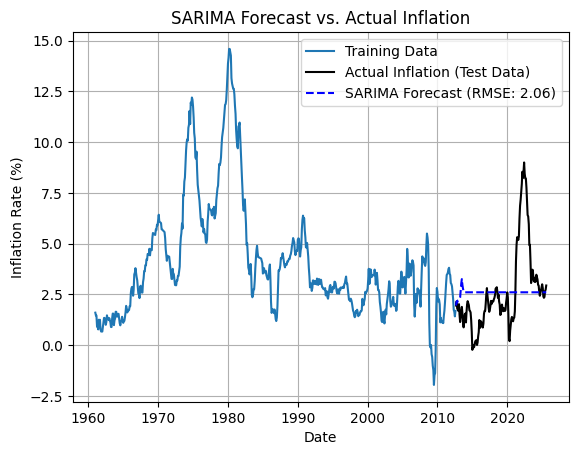

In [30]:
# Plot training data, actual test data, and the SARIMA forecast
plt.plot(train_set['YoY_Inflation'], label='Training Data')
plt.plot(test_set['YoY_Inflation'], label='Actual Inflation (Test Data)', color='black', linewidth=1.5)
plt.plot(prediction_series_sarima, label=f'SARIMA Forecast (RMSE: {rmse_sarima:.2f})', color='blue', linestyle='--')

# Add titles and labels
plt.title('SARIMA Forecast vs. Actual Inflation')
plt.xlabel('Date')
plt.ylabel('Inflation Rate (%)')
plt.legend()
plt.grid(True)
plt.show()

c:\Users\vandan_tank\Documents\inflation-forecasting\venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\vandan_tank\Documents\inflation-forecasting\venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\vandan_tank\Documents\inflation-forecasting\venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\vandan_tank\Documents\inflation-forecasting\venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\vandan_tank\Documents\inflation-forecasting\venv\lib\site-packages\


--- Future Forecast (Next 12 Months) ---
2025-09-01    3.060556
2025-10-01    3.111147
2025-11-01    3.062804
2025-12-01    2.945927
2026-01-01    2.790723
2026-02-01    2.877700
2026-03-01    3.148472
2026-04-01    3.160107
2026-05-01    3.295189
2026-06-01    3.354544
2026-07-01    3.360307
2026-08-01    3.248435
Freq: MS, dtype: float64


c:\Users\vandan_tank\Documents\inflation-forecasting\venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


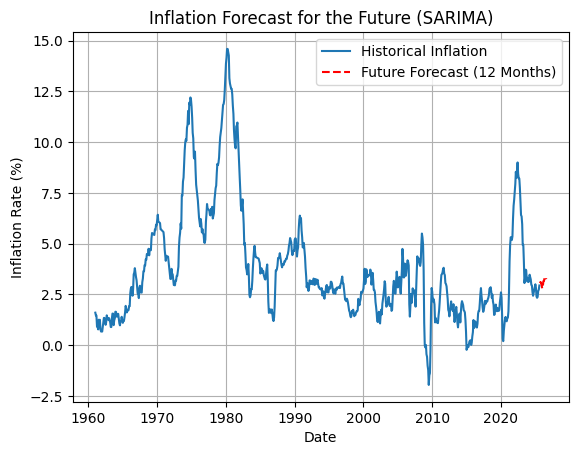

In [31]:
# Re-train the model on the ENTIRE dataset (inflation_df)
# Using the same model parameters found by auto_arima earlier
final_sarima_model = pm.auto_arima(
    inflation_df['YoY_Inflation'], # Use all data
    seasonal=True,
    m=12,
    stepwise=True,
    suppress_warnings=True,
    error_action='ignore',
    trace=False, # No need to show trace this time
    max_p=5, max_q=5, max_P=2, max_Q=2,
    max_d=2, max_D=1,
    start_p=1, start_q=1, start_P=1, start_Q=1
)

# Define how many months to forecast into the future
n_future_periods = 12

# Generate future forecasts
future_preds = final_sarima_model.predict(n_periods=n_future_periods)

# Create a date index for the future forecasts
last_known_date = inflation_df.index[-1]
# Use pandas date_range with 'MS' frequency (Month Start)
future_dates = pd.date_range(start=last_known_date + pd.DateOffset(months=1), periods=n_future_periods, freq='MS')

# Create a pandas Series for the future forecasts
future_series = pd.Series(future_preds, index=future_dates)

# Display the future forecast values
print(f"\n--- Future Forecast (Next {n_future_periods} Months) ---")
print(future_series)

# Plot historical data and the future forecast
plt.plot(inflation_df['YoY_Inflation'], label='Historical Inflation')
plt.plot(future_series, label=f'Future Forecast ({n_future_periods} Months)', color='red', linestyle='--')
plt.title('Inflation Forecast for the Future (SARIMA)')
plt.xlabel('Date')
plt.ylabel('Inflation Rate (%)')
plt.legend()
plt.grid(True)
plt.show()

In [32]:
# Import the ETS model class if you haven't already in Cell 1
from statsmodels.tsa.holtwinters import ExponentialSmoothing

print("\n--- Fitting ETS(AAA) Benchmark Model ---")
# Fit an ETS model (Error=Add, Trend=Add, Seasonality=Add)
# damped_trend=True helps stabilize long-term forecasts
ets_model = ExponentialSmoothing(
    train_set['YoY_Inflation'],
    trend='add',
    seasonal='add',
    seasonal_periods=12,
    damped_trend=True
)
fit_ets = ets_model.fit()

print("\n--- ETS Model Summary ---")
print(fit_ets.summary())


--- Fitting ETS(AAA) Benchmark Model ---

--- ETS Model Summary ---
                       ExponentialSmoothing Model Results                       
Dep. Variable:            YoY_Inflation   No. Observations:                  620
Model:             ExponentialSmoothing   SSE                             83.255
Optimized:                         True   AIC                          -1210.845
Trend:                         Additive   BIC                          -1135.540
Seasonal:                      Additive   AICC                         -1209.578
Seasonal Periods:                    12   Date:                 Fri, 24 Oct 2025
Box-Cox:                          False   Time:                         13:07:27
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               1.000000

c:\Users\vandan_tank\Documents\inflation-forecasting\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [33]:
# Generate ETS predictions for the number of periods in the test set
# The .forecast() method automatically uses the correct dates
predictions_ets = fit_ets.forecast(steps=n_forecast_periods)

# The result is already a pandas Series, store it
prediction_series_ets = predictions_ets

# Display the first few predicted values
print("\n--- ETS Forecasted Values (Test Period Head) ---")
print(prediction_series_ets.head())


--- ETS Forecasted Values (Test Period Head) ---
2012-09-01    1.690886
2012-10-01    1.681202
2012-11-01    1.681771
2012-12-01    1.679805
2013-01-01    1.682356
Freq: MS, dtype: float64


In [34]:
# Calculate RMSE and MAE for the ETS model forecasts
rmse_ets = np.sqrt(mean_squared_error(test_set['YoY_Inflation'], prediction_series_ets))
mae_ets = mean_absolute_error(test_set['YoY_Inflation'], prediction_series_ets)

# Print the ETS model's error metrics
print(f"ETS Model Performance on Test Set:")
print(f"  RMSE: {rmse_ets:.4f}")
print(f"  MAE:  {mae_ets:.4f}")

ETS Model Performance on Test Set:
  RMSE: 2.2708
  MAE:  1.4302


In [35]:
# Print the metrics for both models
print("\n--- Model Comparison on Test Set ---")
print(f"SARIMA - RMSE: {rmse_sarima:.4f}, MAE: {mae_sarima:.4f}")
print(f"ETS    - RMSE: {rmse_ets:.4f}, MAE: {mae_ets:.4f}")

# Determine which model performed better based on RMSE (lower is better)
if rmse_sarima < rmse_ets:
    print("\n---> SARIMA performed better based on RMSE.")
else:
    print("\n---> ETS performed better (or equally well) based on RMSE.")


--- Model Comparison on Test Set ---
SARIMA - RMSE: 2.0614, MAE: 1.4520
ETS    - RMSE: 2.2708, MAE: 1.4302

---> SARIMA performed better based on RMSE.


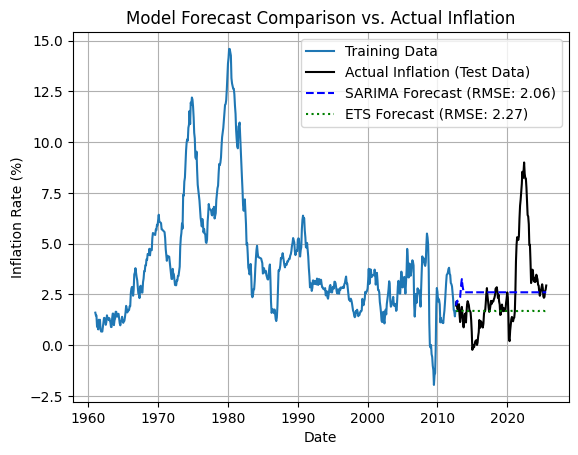

In [36]:
# Create the plot
plt.plot(train_set['YoY_Inflation'], label='Training Data')
plt.plot(test_set['YoY_Inflation'], label='Actual Inflation (Test Data)', color='black', linewidth=1.5)
plt.plot(prediction_series_sarima, label=f'SARIMA Forecast (RMSE: {rmse_sarima:.2f})', color='blue', linestyle='--')
plt.plot(prediction_series_ets, label=f'ETS Forecast (RMSE: {rmse_ets:.2f})', color='green', linestyle=':') # Added ETS plot

# Add titles, labels, legend, and grid
plt.title('Model Forecast Comparison vs. Actual Inflation')
plt.xlabel('Date')
plt.ylabel('Inflation Rate (%)')
plt.legend()
plt.grid(True)
plt.show()


--- Generating Future Forecast using SARIMA ---


c:\Users\vandan_tank\Documents\inflation-forecasting\venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\vandan_tank\Documents\inflation-forecasting\venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\vandan_tank\Documents\inflation-forecasting\venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\vandan_tank\Documents\inflation-forecasting\venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\vandan_tank\Documents\inflation-forecasting\venv\lib\site-packages\


--- SARIMA Future Forecast (Next 12 Months) ---
2025-09-01    3.060556
2025-10-01    3.111147
2025-11-01    3.062804
2025-12-01    2.945927
2026-01-01    2.790723
2026-02-01    2.877700
2026-03-01    3.148472
2026-04-01    3.160107
2026-05-01    3.295189
2026-06-01    3.354544
2026-07-01    3.360307
2026-08-01    3.248435
Freq: MS, dtype: float64


c:\Users\vandan_tank\Documents\inflation-forecasting\venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


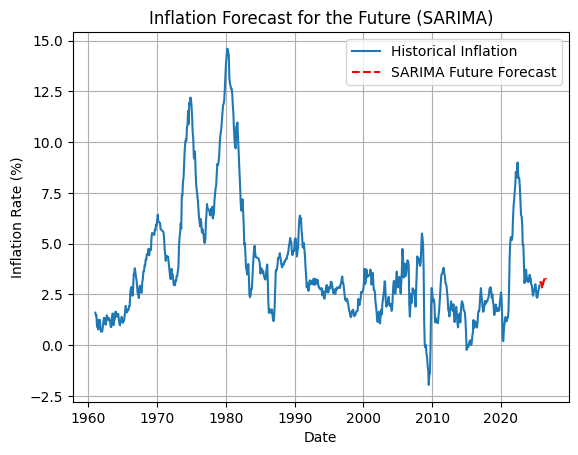

In [37]:
# Select the best model based on RMSE
best_model_name = 'SARIMA' if rmse_sarima < rmse_ets else 'ETS'
print(f"\n--- Generating Future Forecast using {best_model_name} ---")

n_future_periods = 12 # Define number of months to forecast

# Re-train the chosen model (SARIMA in this case) on the full dataset
final_model = pm.auto_arima(
    inflation_df['YoY_Inflation'], # Use all data (train + test)
    seasonal=True,
    m=12,
    stepwise=True,
    suppress_warnings=True,
    error_action='ignore',
    trace=False, # No need to show trace
    # Re-use the same search parameters
    max_p=5, max_q=5, max_P=2, max_Q=2,
    max_d=2, max_D=1,
    start_p=1, start_q=1, start_P=1, start_Q=1
)

# Generate forecasts
future_preds = final_model.predict(n_periods=n_future_periods)

# Create future date index
last_known_date = inflation_df.index[-1]
future_dates = pd.date_range(start=last_known_date + pd.DateOffset(months=1), periods=n_future_periods, freq='MS')
future_series = pd.Series(future_preds, index=future_dates)

# Display forecast
print(f"\n--- {best_model_name} Future Forecast (Next {n_future_periods} Months) ---")
print(future_series)

# Plot historical data and the future forecast
plt.plot(inflation_df['YoY_Inflation'], label='Historical Inflation')
plt.plot(future_series, label=f'{best_model_name} Future Forecast', color='red', linestyle='--')
plt.title(f'Inflation Forecast for the Future ({best_model_name})')
plt.xlabel('Date')
plt.ylabel('Inflation Rate (%)')
plt.legend()
plt.grid(True)
plt.show()